**Before starting:**

You need to install Basemap. Do it only once.

In [1]:
!pip install basemap

**Goal of this practice:**

In this second practice, we will use the "BigQuery" technology which uses a network of computers at Google. We still use the Google Colab to run this Jupyter notebook and interact with the Google Cloud Platform. We will work directly on the whole database (1998-2015, 150Go) and you will perform basic statistics. The idea is to show that BigQuery is able to manage very large datasets efficiently (few seconds). We will manipulate the SST/SSH dataset with BigQuery using the magic command *%%bigquery*.

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [2]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,15) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_map_global and plot_map_local (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [3]:
# function to plot images
def plot_map_global(lon, lat, map, size_points, var_name, cmap):

    # transform to arrays (just in case)
    lon = array(lon)
    lat = array(lat)
    map = array(map)

    # Orthogonal projection (for large zone)
    m = Basemap(projection='robin', lat_0=0, lon_0=0, resolution='i')

    # transform (lon,lat) to (x,y)
    x, y = m(lon, lat)

    # plot
    res = m.scatter(x, y, size_points, map, 'o', alpha=1, cmap=cmap, lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat), nanmax(lat), 15)
    meridians = linspace(nanmin(lon), nanmax(lon), 15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb = m.colorbar(res, location="bottom")
    cb.set_label(var_name, fontsize=30)
    cb.ax.tick_params(labelsize=15)

# function to plot images
def plot_map_local(lon, lat, map, size_points, var_name, cmap, ll_lat, ur_lat, ll_lon, ur_lon):

    # transform to arrays (just in case)
    lon = array(lon)
    lat = array(lat)
    map = array(map)

    # Mercator projection (for small zone)
    m=Basemap(projection='merc', llcrnrlat=ll_lat, urcrnrlat=ur_lat,\
      llcrnrlon=ll_lon, urcrnrlon=ur_lon, resolution='i')

    # transform (lon,lat) to (x,y)
    x, y = m(lon, lat)

    # plot
    res = m.scatter(x, y, size_points, map, 'o', alpha=1, cmap=cmap, lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat), nanmax(lat), 15)
    meridians = linspace(nanmin(lon), nanmax(lon), 15)
    #m.drawparallels(parallels, labels=[1,0,0,1], fontsize=10)
    #m.drawmeridians(meridians, labels=[1,0,0,1], fontsize=10)
    cb = m.colorbar(res, location="bottom")
    cb.set_label(var_name, fontsize=30)
    cb.ax.tick_params(labelsize=15)

# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time-719177.25,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. In order to get the login and password, please contact me at pierre.tandeo@imt-atlantique.fr.

In [4]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

The Google Cloud Platform has set up a tool to handle large databases. This is called "BigQuery" and it is based on the NoSQL ("Not only SQL") language. The syntaxe in BigQuery is very similar to the pandas example given in the first practice. SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc... Here you will find the list of basic functions: https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=fr.


**Figure 2-a: GLOBAL CORRELATION BETWEEN SST AND SSH**

Plot the global map of the correlation between SST and SSH for the period 1998-2015.

In [5]:
%%bigquery output1 --project alert-ground-261008
SELECT
lon, lat, AVG(sst) AS sst_im, AVG(ssh) AS ssh_im, CORR(sst,ssh) AS sst_ssh_corr
FROM
bdo2020.bdo2020.1998_2015
GROUP BY
lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

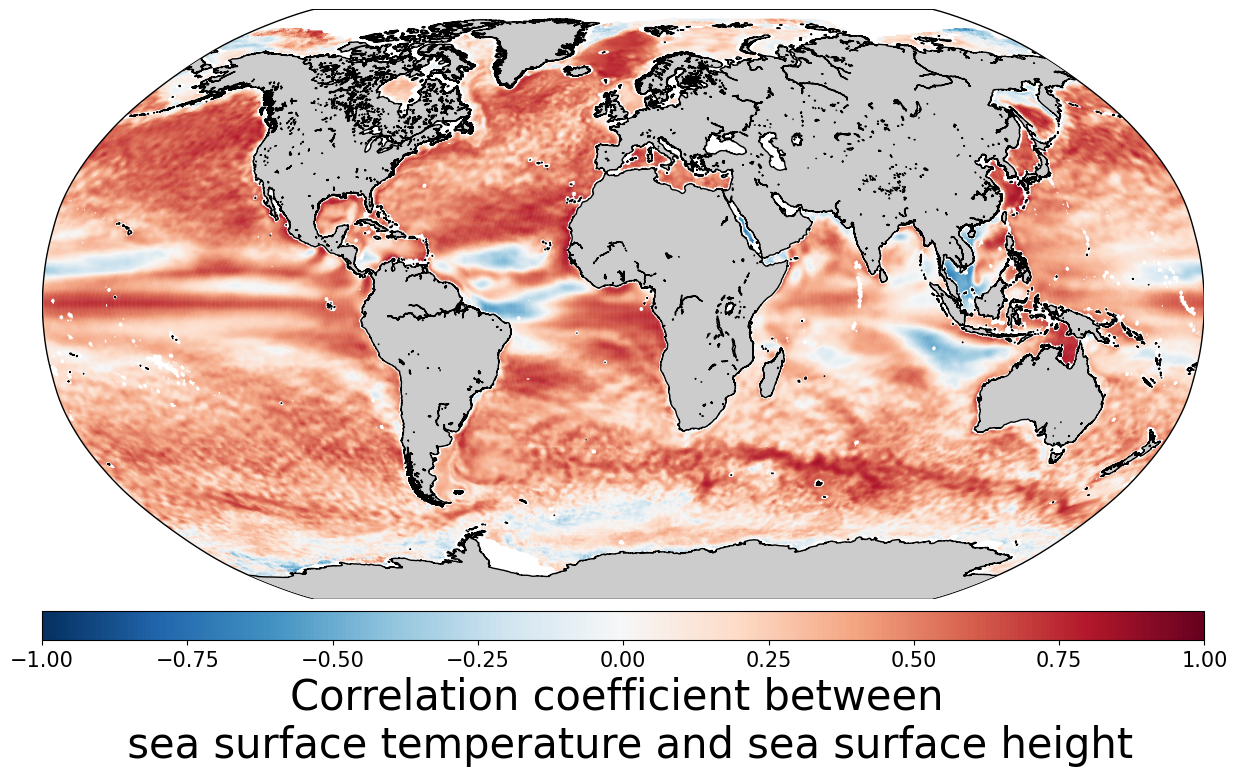

In [9]:
plot_map_global(output1.lon, output1.lat, output1.sst_ssh_corr, 1, 'Correlation coefficient between \n sea surface temperature and sea surface height', 'RdBu_r')
clim([-1,1])

**Figure 2-b: CORRELATION BETWEEEN SST AND SSH IN THE GULF OF MEXICO**

In the Gulf of Mexico (270<lon<274 and 24<lat<28), plot the seasonal cycle of the SST/SSH correlation.

In [10]:
%%bigquery output2 --project alert-ground-261008
SELECT time, month, CORR(sst, ssh) AS corr_sst_ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>270 AND lon<274 AND lat>24 AND lat<28
GROUP BY time, month
ORDER BY time, month

Query is running:   0%|          |

Downloading:   0%|          |

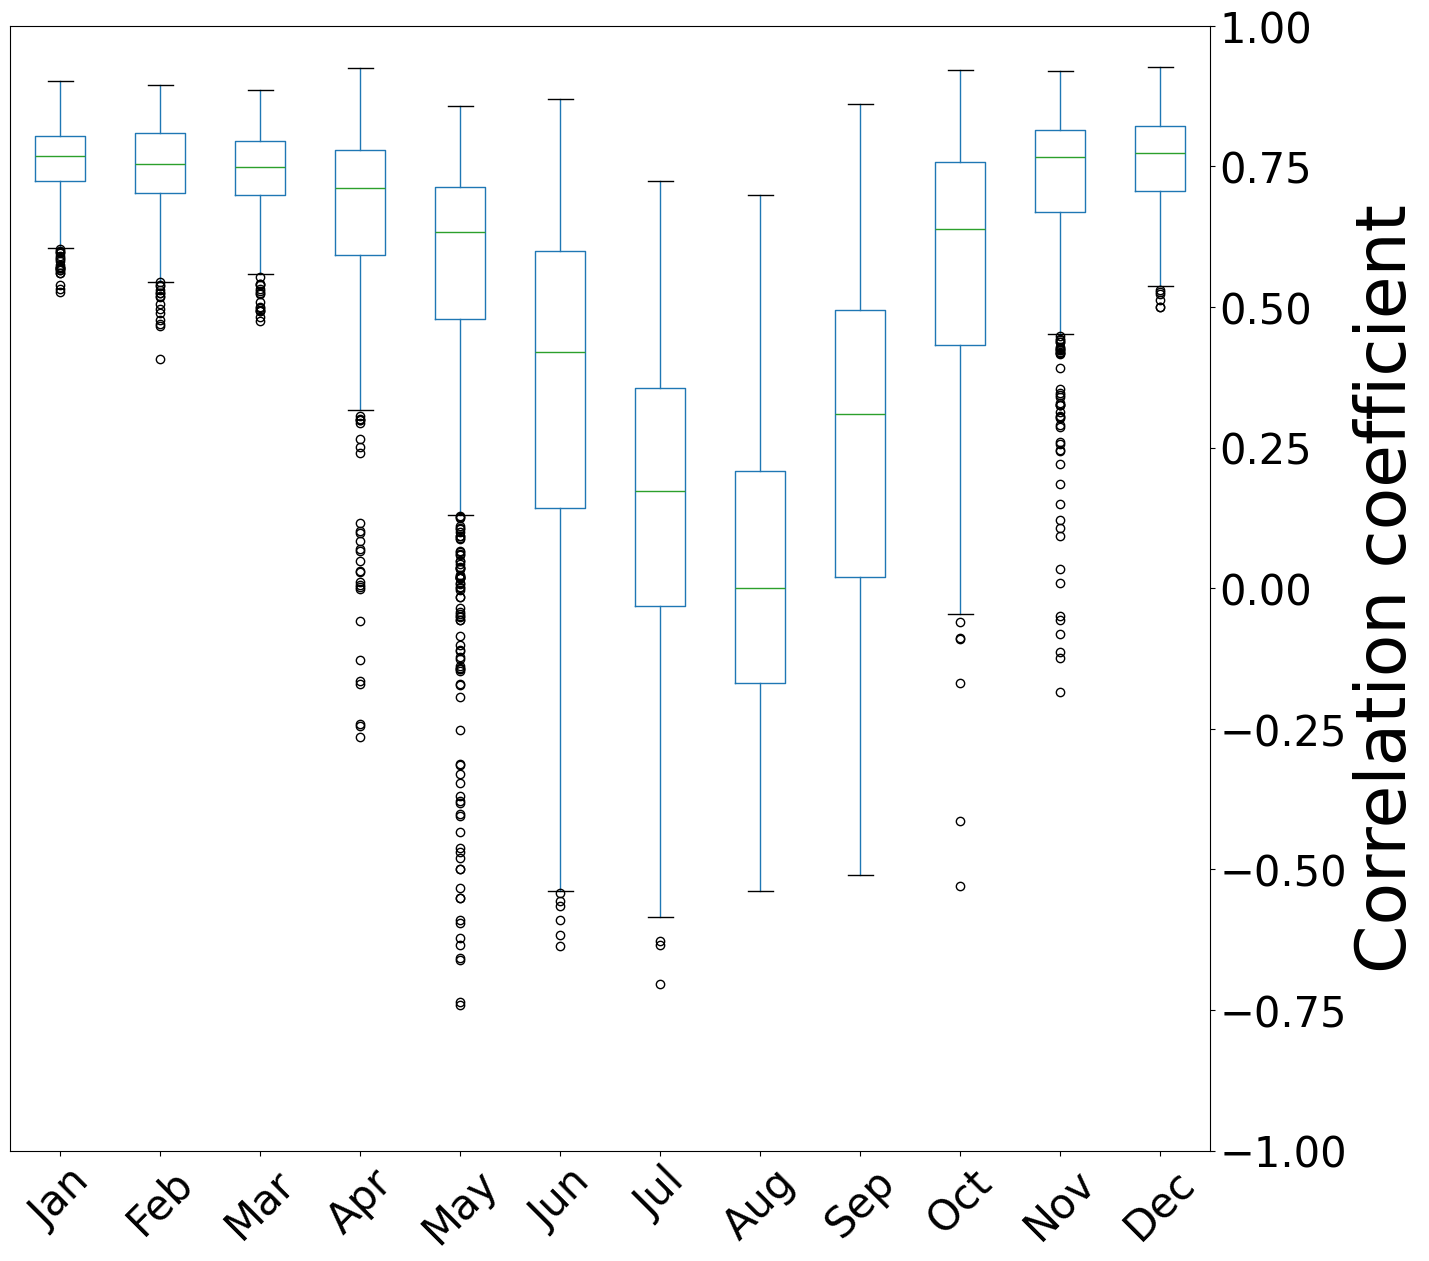

In [17]:
# boxplot of the correlation for each month
fig, ax = plt.subplots()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
output2.boxplot(column='corr_sst_ssh', by='month', grid=False, fontsize=30, rot=45, ax=ax)
ax.set_xticks(range(1, len(month_order) + 1))
ax.set_xticklabels(month_order)
#title('Correlation between SST and SSH \n in the Gulf of Mexico', fontsize=50)
title("")
suptitle("")
xlabel("")
ylabel('Correlation coefficient', fontsize=50)
ylim([-1,1])
gca().yaxis.tick_right()
gca().yaxis.set_label_position("right")

**Figure 2: SEA LEVEL RISE**

In [36]:
# extract the daily SSH from satellite data
%%bigquery output3 --project alert-ground-261008
SELECT time, AVG(ssh) AS mean_ssh , STDDEV(ssh) AS std_ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lat>-35 AND lat<35
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [37]:
# import xarray and zarr
import xarray as xr
import sys
import gcsfs
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as tmpdirname:
    sys.path.append(tmpdirname)
    repo = "https://raw.githubusercontent.com/obidam/ds2-2024/main/"
    urllib.request.urlretrieve(os.path.join(repo, "utils.py"),
                               os.path.join(tmpdirname, "utils.py"))
    from utils import check_up_env
    check_up_env()
from intake import open_catalog
import intake

In [38]:
# connect to CMIP6 data
gcs = gcsfs.GCSFileSystem(token='anon')
df_full = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#df_full.sample(10)

In [40]:
# extract data of sea level rise from CMIP6

from tqdm import tqdm
nb_members = 127
scenarios = ['ssp126', 'ssp585'] # issue for ssp245
nb_scenarios = len(scenarios)

# Stores processed data for each dataset
zostoga_values = zeros((nb_scenarios, nb_members, 1032)) # until 2100
time_values_length = None

# loop on CMIP6 experiments
for i in range(nb_scenarios):
  for m in tqdm(range(nb_members)):

    # condition
    cond = "(variable_id=='zostoga' & table_id == 'Omon' & experiment_id == '" + scenarios[i] + "' )"
    df = df_full.query(cond)
    df = df.sort_values('version', ascending=False)

    # get the path to a specific zarr store (the first one from the dataframe above)
    zstore = df.zstore.values[m]
    #print(zstore)

    # create a mutable-mapping-style interface to the store
    #gcs = gcsfs.GCSFileSystem(token='anon') # This line is likely redundant as 'gcs' is already defined.
    # Instead of using get_mapper, directly pass the zstore path to open_zarr
    # and provide the gcs filesystem object through storage_options

    # open it using xarray and zarr
    ds = xr.open_zarr(zstore, consolidated=True, storage_options={'token': 'anon'}) # Changed line
    #print("Size of the dataset:", ds.nbytes / 1e9, "Gb")

    # Subtract the first value of zostoga from all values and store in the list
    processed_values = ds.zostoga.values - ds.zostoga.values[0]#+0.02272397

    # If it is the first iteration, record the length of the timeline
    if time_values_length is None:
        time_values_length = len(ds.time)

    # Check if the timeline length is consistent, if not then truncate or padding
    if len(ds.time) != time_values_length:
        processed_values = processed_values[:time_values_length]

    # Stock values
    zostoga_values[i,m,:] = ravel(processed_values)

100%|██████████| 127/127 [01:47<00:00,  1.19it/s]


In [41]:
# from the CMIP6 ensembles, compute different quantiles

from statsmodels.stats.weightstats import DescrStatsW
col_scenarios = ['b', 'r']
time = linspace(2014, 2100, 1032)

# compute weighted quantiles
zostoga_values_quantiles = zeros((nb_scenarios, 1032, 3))
for i in range(nb_scenarios):
  for t in range(1032):
    wq = DescrStatsW(data=zostoga_values[i,:,t])
    zostoga_values_quantiles[i,t,:] = wq.quantile(probs=np.array([0.025, 0.5, 0.975]), return_pandas=False)

In [43]:
# adjust a linear regression to the SSH from altimetry

import sklearn
from sklearn.linear_model import LinearRegression

# time periods for training and prediction
time_train = linspace(1998, 2016, len(output3.time))
time_pred  = linspace(2016, 2100, 30690)

# seasonal components
sin_time_train = sin(2 * pi * time_train)
cos_time_train = cos(2 * pi * time_train)
sin_time_pred  = sin(2 * pi * time_pred)
cos_time_pred  = cos(2 * pi * time_pred)

# X for training and prediction
X_train = c_[time_train, sin_time_train, cos_time_train]
X_pred  = c_[time_pred,  sin_time_pred,  cos_time_pred]

# model with linear trend and seasonal component
model_slr = LinearRegression().fit(X_train, output3.mean_ssh)

# order 1 autoregressive process for epsilon
slr_pred_train = model_slr.predict(X_train)
epsilon = output3.mean_ssh - slr_pred_train
epsilon_values = epsilon.to_numpy()
model_epsilon = LinearRegression(fit_intercept=False).fit(epsilon_values[0:-1, None], epsilon_values[1:, None])
c = ravel(model_epsilon.coef_)
sigma2 = var(epsilon[1:] - c * epsilon[0:-1])

# variance of the prediction in the future
slr_var = zeros((30690))
slr_var[0] = var(output3.mean_ssh - slr_pred_train)
for t in range(30689):
  slr_var[t+1] = c**2 * slr_var[t] + t*sigma2

# prediction in the future
slr_pred = model_slr.predict(X_pred)
slr_pred_inf = slr_pred - 1.96 * sqrt(slr_var)
slr_pred_sup = slr_pred + 1.96 * sqrt(slr_var)

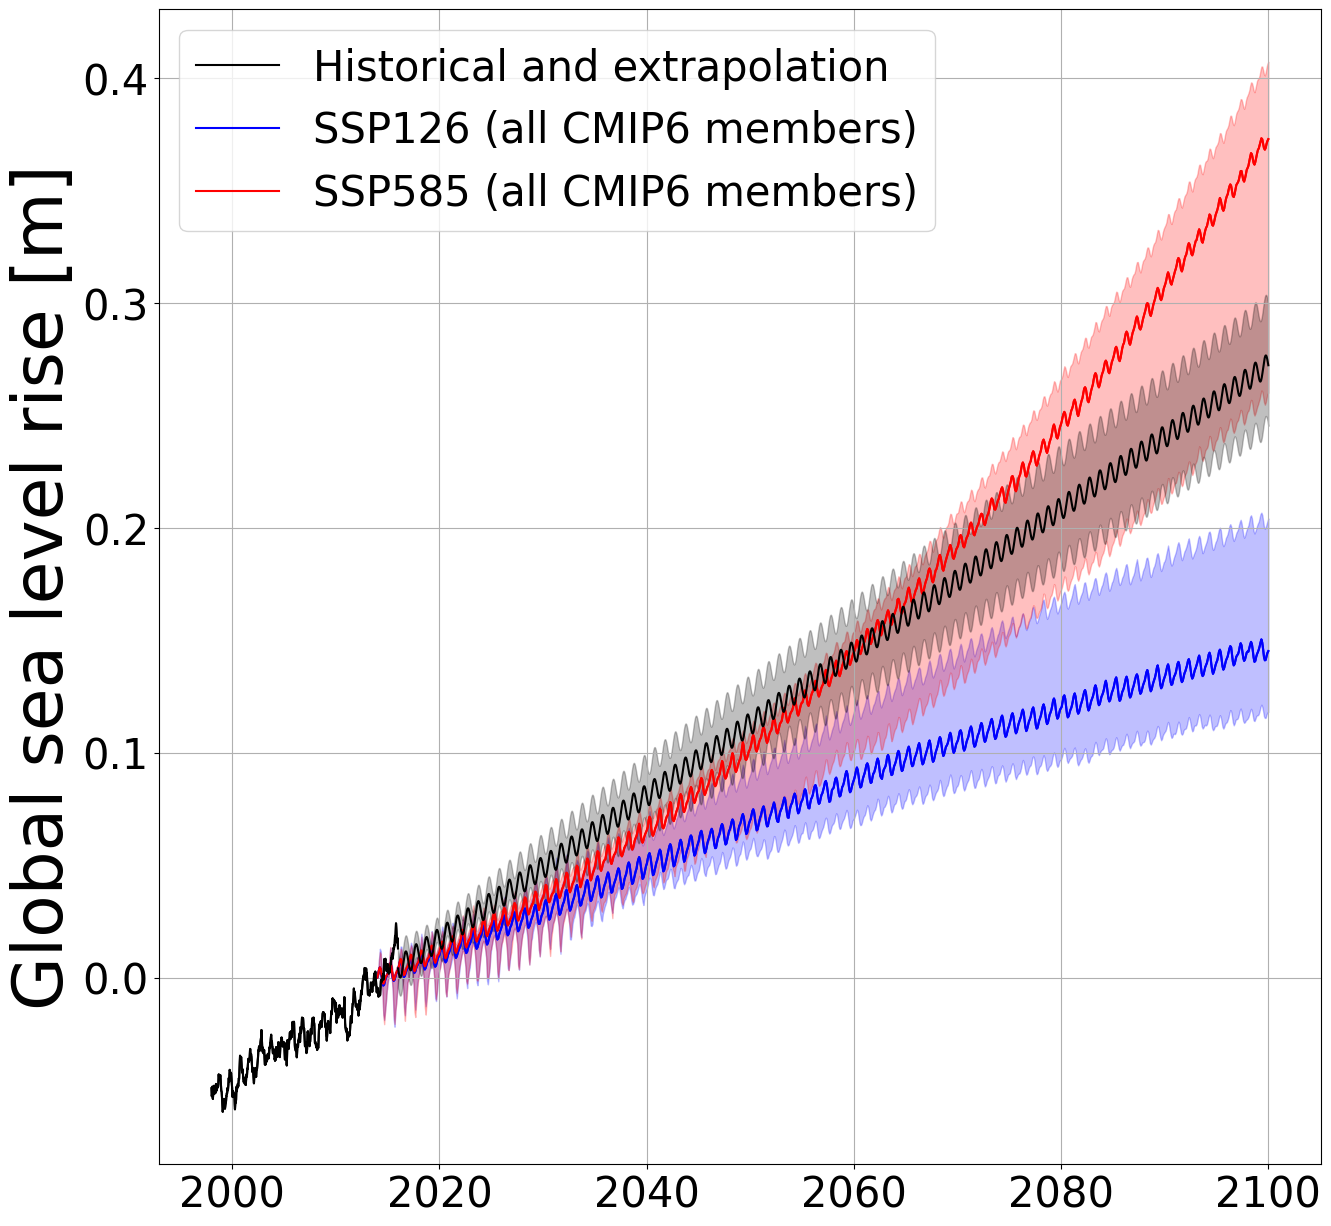

In [57]:
# for the legend
shift = mean(output3.mean_ssh[(-365*2):-365]) # value of the mean SSH in 2014 (i.e., beginning of CMIP6 simulations)
plot(time_train, output3.mean_ssh - shift, 'k')
plot(time, zostoga_values_quantiles[0,:,1], col_scenarios[0])
plot(time, zostoga_values_quantiles[1,:,1], col_scenarios[1])
legend(['Historical and extrapolation', 'SSP126 (all CMIP6 members)', 'SSP585 (all CMIP6 members)'], fontsize=30)
tick_params(axis='both', which='major', labelsize=30)
grid()

# plot quantiles (Q2.5%, Q50%, Q97.5%) for each scenario
for i in range(nb_scenarios):
  plot(time, zostoga_values_quantiles[i,:,1], col_scenarios[i])
  fill_between(time, zostoga_values_quantiles[i,:,0], zostoga_values_quantiles[i,:,2], alpha=0.25, color=col_scenarios[i])
  #plot(time, zostoga_values[i,:,:].T, alpha=0.1, color=col_scenarios[i])

# plot satellite observations
plot(time_train, output3.mean_ssh - shift, 'k')
ylabel('Global sea level rise [m]', fontsize=50)

# plot statistical projections
plot(time_pred, slr_pred - shift, 'k')
fill_between(time_pred, slr_pred_inf - shift, slr_pred_sup - shift, alpha=0.25, color='k')

**Figure 3: MARINE HEAT WAVES**

In [58]:
%%bigquery data_mhw --project alert-ground-261008
SELECT lon, lat, year, SUM(exceed) AS duration, SUM(exceed*(sst-(sst_mean+1.285*sst_std))) AS intensity
FROM (
  SELECT lon, lat, year, sst, sst_mean, sst_std, CASE WHEN sst > sst_mean+1.285*sst_std THEN 1 ELSE 0 END AS exceed
  FROM (
    SELECT lon, lat, year, sst, AVG(sst) OVER (PARTITION BY dayofyear, CAST(lon as STRING), CAST(lat as STRING)) AS sst_mean, STDDEV(sst) OVER (PARTITION BY dayofyear, CAST(lon as STRING), CAST(lat as STRING)) AS sst_std
    FROM bdo2020.bdo2020.1998_2015_withtimes
    WHERE (lon>355 OR lon<40) AND lat>25 AND lat<50 AND (month=6 OR month=7 OR month=8)
    ORDER BY lon, lat, year)
  ORDER BY lon, lat, year)
GROUP BY lon, lat, year

Query is running:   0%|          |

Downloading:   0%|          |

In [59]:
%%bigquery data_mhw_2003_2012 --project alert-ground-261008
SELECT lon, lat, time, year, sst, sst_mean+1.285*sst_std AS sst_treshold, CASE WHEN sst > sst_mean+1.285*sst_std THEN 1 ELSE 0 END AS exceed
FROM (
  SELECT lon, lat, time, year, sst, AVG(sst) OVER (PARTITION BY dayofyear, CAST(lon as STRING), CAST(lat as STRING)) AS sst_mean, STDDEV(sst) OVER (PARTITION BY dayofyear, CAST(lon as STRING), CAST(lat as STRING)) AS sst_std
  FROM bdo2020.bdo2020.1998_2015_withtimes
  WHERE (lon>355 OR lon<40) AND lat>25 AND lat<50 # AND (month=6 OR month=7 OR month=8)
  ORDER BY lon, lat, year)
WHERE year=2003 OR year=2012
ORDER BY lon, lat, time

Query is running:   0%|          |

Downloading:   0%|          |

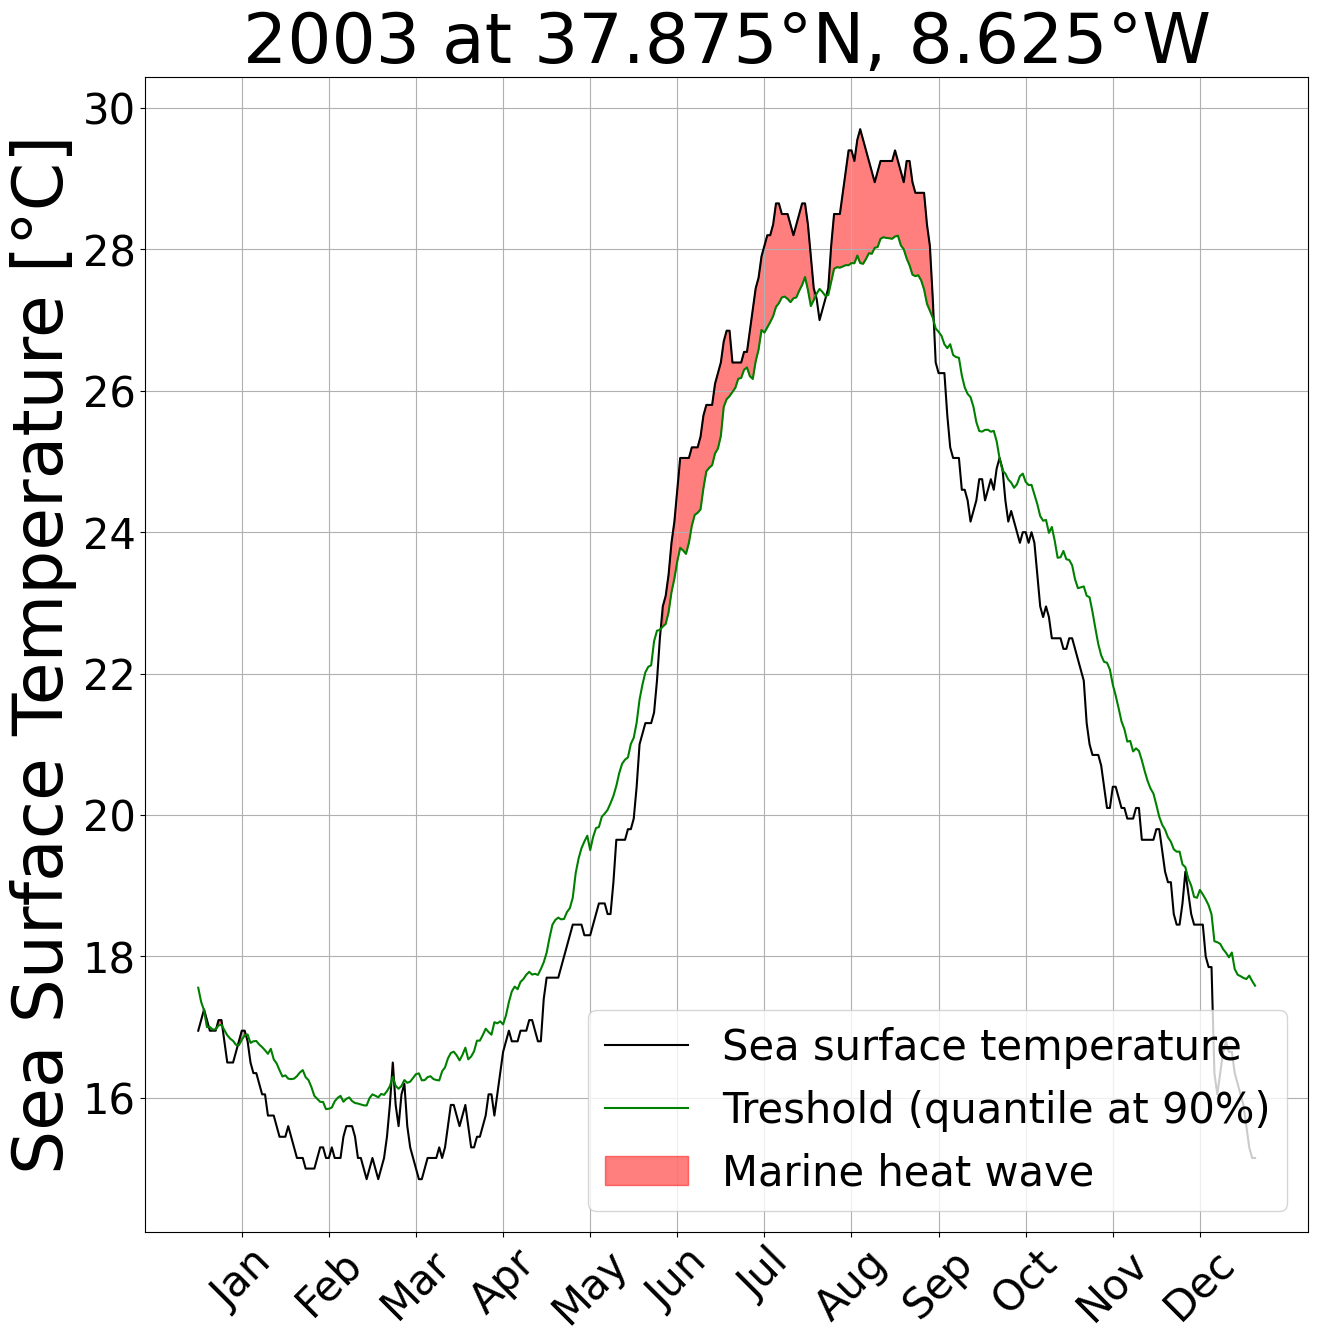

In [127]:
# plot time series of MHW in 2003
data_mhw_2003 = data_mhw_2003_2012[(data_mhw_2003_2012.year==2003) & (data_mhw_2003_2012.lon==8.625) & (data_mhw_2003_2012.lat==37.875)]
plot(data_mhw_2003.time, data_mhw_2003.sst, 'k')
plot(data_mhw_2003.time, data_mhw_2003.sst_treshold, 'g')
fill_between(data_mhw_2003.time, data_mhw_2003.sst, data_mhw_2003.sst_treshold, data_mhw_2003.exceed, color = 'r', alpha = 0.5)
xticks([array(data_mhw_2003.time)[15], array(data_mhw_2003.time)[45], array(data_mhw_2003.time)[75],
        array(data_mhw_2003.time)[105], array(data_mhw_2003.time)[135], array(data_mhw_2003.time)[165],
        array(data_mhw_2003.time)[195], array(data_mhw_2003.time)[225], array(data_mhw_2003.time)[255],
        array(data_mhw_2003.time)[285], array(data_mhw_2003.time)[315], array(data_mhw_2003.time)[345]],
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
tick_params(axis='both', which='major', labelsize=30)
grid()
ylabel('Sea Surface Temperature [°C]', fontsize=50)
title('2003 at 37.875°N, 8.625°W', fontsize=50)
legend(['Sea surface temperature', 'Treshold (quantile at 90%)', 'Marine heat wave'], fontsize=30, loc=4)

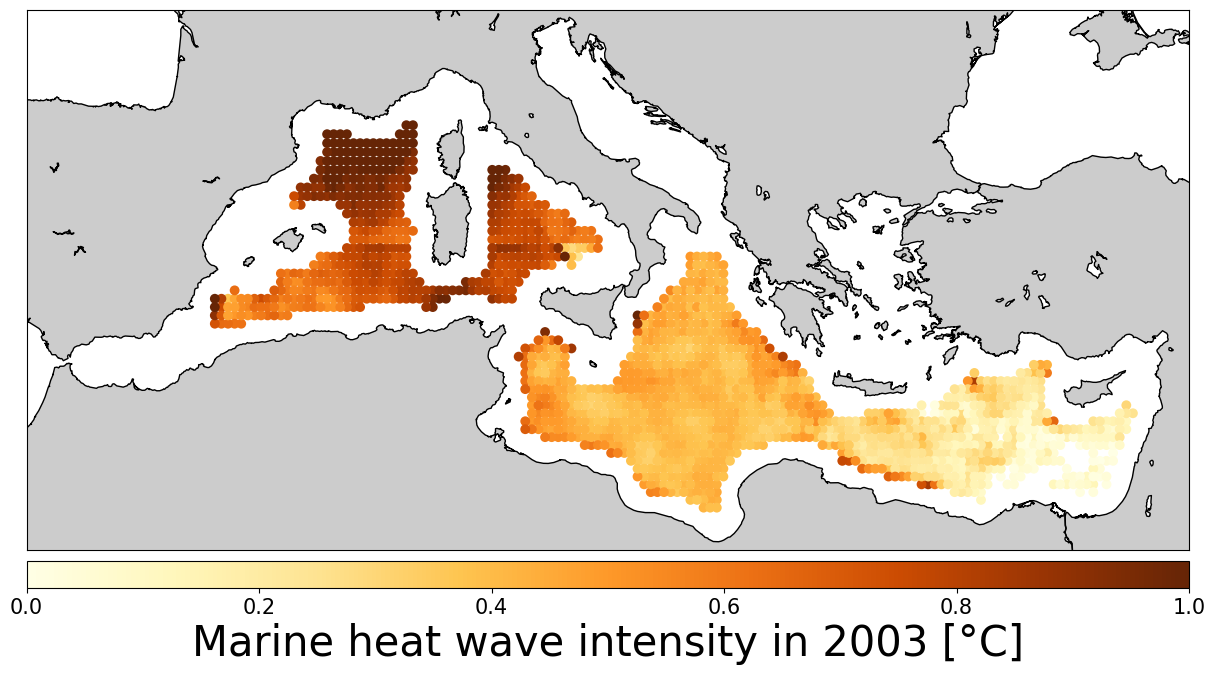

In [128]:
# plot map of MHW in 2003
#plot_map_local(8.625, 37.875, 1, 1000, 'Marine heat wave intensity in 2003 [°C]', 'YlOrBr', 30, 46, -7, 37)
plot_map_local(data_mhw[data_mhw.year==2003].lon, data_mhw[data_mhw.year==2003].lat,
               data_mhw[data_mhw.year==2003].intensity / data_mhw[data_mhw.year==2003].duration, 50, 'Marine heat wave intensity in 2003 [°C]', 'YlOrBr', 30, 46, -7, 37)
clim([0,1])

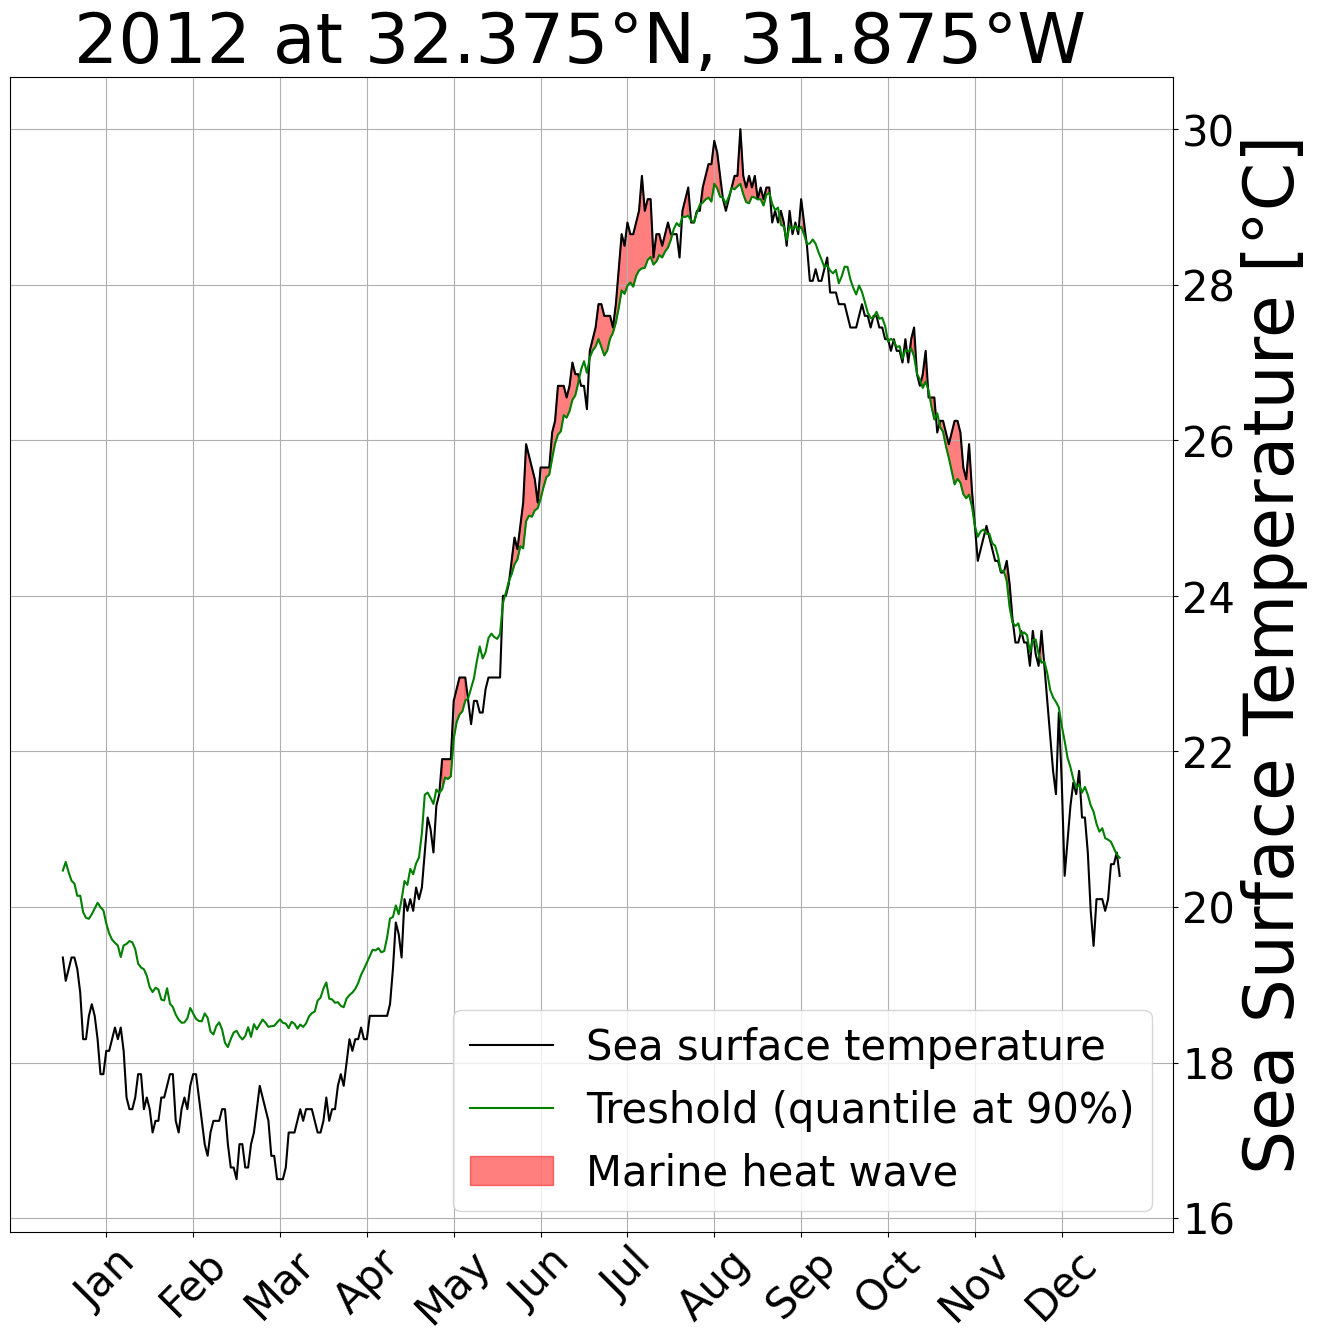

In [138]:
# plot time series of MHW in 2012
data_mhw_2012 = data_mhw_2003_2012[(data_mhw_2003_2012.year==2012) & (data_mhw_2003_2012.lon==31.875) & (data_mhw_2003_2012.lat==32.375)]
plot(data_mhw_2012.time, data_mhw_2012.sst, 'k')
plot(data_mhw_2012.time, data_mhw_2012.sst_treshold, 'g')
fill_between(data_mhw_2012.time, data_mhw_2012.sst, data_mhw_2012.sst_treshold, data_mhw_2012.exceed,
             color = 'r', alpha = 0.5)
xticks([array(data_mhw_2012.time)[15], array(data_mhw_2012.time)[45], array(data_mhw_2012.time)[75],
        array(data_mhw_2012.time)[105], array(data_mhw_2012.time)[135], array(data_mhw_2012.time)[165],
        array(data_mhw_2012.time)[195], array(data_mhw_2012.time)[225], array(data_mhw_2012.time)[255],
        array(data_mhw_2012.time)[285], array(data_mhw_2012.time)[315], array(data_mhw_2012.time)[345]],
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
tick_params(axis='both', which='major', labelsize=30)
grid()
ylabel('Sea Surface Temperature [°C]', fontsize=50)
title('2012 at 32.375°N, 31.875°W ', fontsize=50)
legend(['Sea surface temperature', 'Treshold (quantile at 90%)', 'Marine heat wave'], fontsize=30, loc=4)
gca().yaxis.tick_right()
gca().yaxis.set_label_position("right")

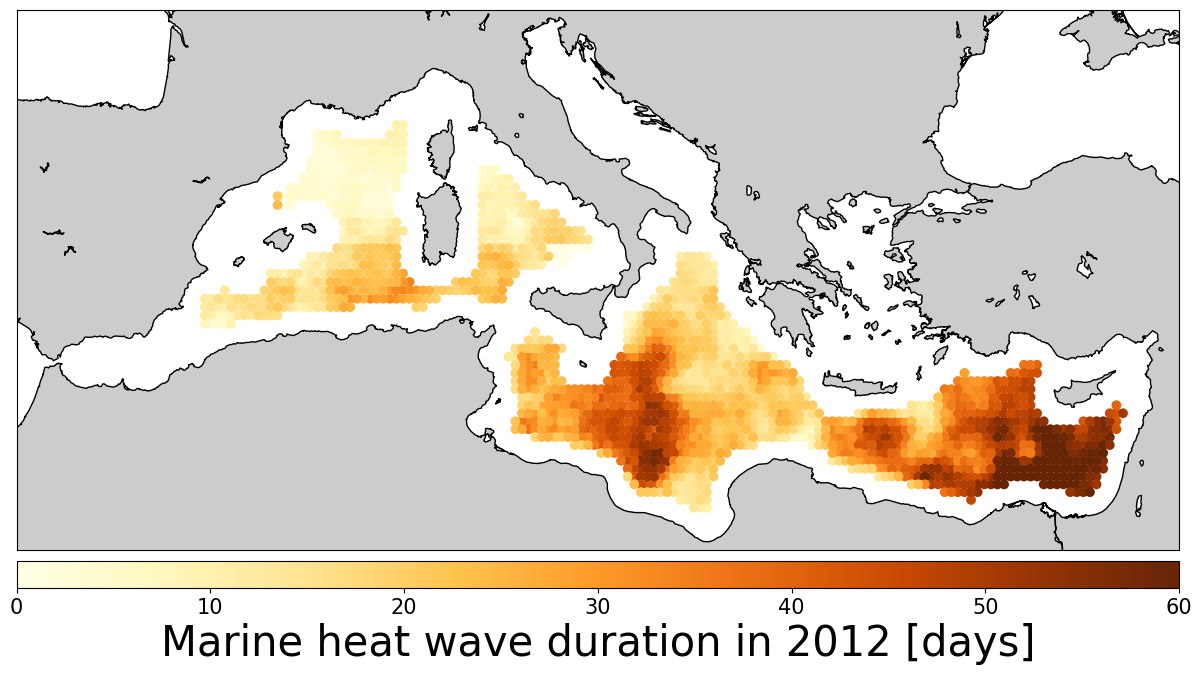

In [132]:
# plot MHW in 2012
#plot_map_local(31.875, 32.375, 1, 1000, 'Marine heat wave intensity in 2012 [°C]', 'YlOrBr', 30, 46, -7, 37)
plot_map_local(data_mhw[data_mhw.year==2012].lon, data_mhw[data_mhw.year==2012].lat,
               data_mhw[data_mhw.year==2012].duration, 50, 'Marine heat wave duration in 2012 [days]', 'YlOrBr', 30, 46, -7, 37)
clim([0,60])